<a href="https://colab.research.google.com/github/tylerganter/deep-practice/blob/master/dlwp/dlwp_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with Python
## 3.4 Classifying movie reviews: a binary classification example

## Setup / Config

In [2]:
!pip uninstall tensorflow-gpu
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 41.8MB/s 
     |████████████████████████████████| 3.8MB 33.9MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [0]:
import json
import os
import psutil
import random
import time

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import imdb

In [0]:
assert tf.__version__ == "2.0.0", "Unexpected version of tensorflow: {}".format(tf.__version__)
assert tf.test.is_gpu_available(), "No GPU found!"

In [5]:
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/colab_mounts/dlwp_3.4'
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/colab_mounts/dlwp_3.4
model_000.h5	model_014.json	model_029.h5	model_043.json	model_058.h5
model_000.json	model_015.h5	model_029.json	model_044.h5	model_058.json
model_001.h5	model_015.json	model_030.h5	model_044.json	model_059.h5
model_001.json	model_016.h5	model_030.json	model_045.h5	model_059.json
model_002.h5	model_016.json	model_031.h5	model_045.json	model_060.h5
model_002.json	model_017.h5	model_031.json	model_046.h5	model_060.j

In [6]:
def colab_time_left():
  start_time = time.time() - psutil.boot_time()
  time_left = 12 - start_time / 3600
  print('Time remaining for this colab session is: {:.2f} hrs'.format(time_left))
colab_time_left()

Time remaining for this colab session is: 11.81 hrs


## Util Functions

In [0]:
#
# JSON
#

def is_jsonable(value):
    try:
        json.dumps(value)
        return True
    except:
        return False

def json_safe(value):
  return value if is_jsonable(value) else str(value)

def serialize(d):
  d = {json_safe(k): json_safe(v) for k, v in d.items()}
  return json.dumps(d)

def read_json(filepath):
  with open(filepath) as infile:
    data = json.load(infile)
  return data

def write_json(d, filepath):
  json_str = serialize(d)
  with open(filepath, 'w') as outfile:
    json.dump(data, outfile)


## Load Data

In [8]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


In [9]:
print("Num training samples: {}".format(train_data.shape[0]))
print("Num test samples:     {}".format(test_data.shape[0]))
print("Max input value: {}".format(max(max(x) for x in train_data)))
print("Max word count: {}".format(max(len(x) for x in train_data + test_data)))

Num training samples: 25000
Num test samples:     25000
Max input value: 9999
Max word count: 2697


In [10]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

labels_map = ["negative", "positive"]

def decode_review(train_sample):
  return ' '.join([reverse_word_index.get(i - 3, '?') for i in train_sample])

1646592/1641221 [==============================] - 0s 0us/step


In [11]:
IDX = random.randint(0, len(train_data))

print("Training sample {}".format(IDX))
print(decode_review(train_data[IDX]))
print("Label: {}".format(labels_map[train_labels[IDX]]))

Training sample 18030
? i saw chan is missing when it first came out about four years after moving from san francisco to new york maybe it was the perspective of a few years away but this movie seemed to capture the essence of the city and its people better than anything else i'd ever seen still does it concentrates on one particular community the chinese but that's fine because so much of the city's soul is ? through the settings the faces and the maybe above all the voices of the characters br br this isn't the ? san francisco the settings are humble and everyday a taxi cab the kitchen of a chinese restaurant ? district row houses little ? apartments and small business ? the ? a ? elder center this is what the city looks and feels like day to day to the people who live there even now in the era of ? ? urban ? unlike say dirty harry in its own way an excellent san francisco movie as well everything is filmed at street level we come to understand the characters' points of view from the

## Transform Data

In [0]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## Define the model, train and evaluate


In [0]:
model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [0]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [15]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 185us/sample - loss: 0.5266 - accuracy: 0.7964 - val_loss: 0.4250 - val_accuracy: 0.8471
Epoch 2/20
15000/15000 [==============================] - 1s 72us/sample - loss: 0.3277 - accuracy: 0.9014 - val_loss: 0.3200 - val_accuracy: 0.8851
Epoch 3/20
15000/15000 [==============================] - 1s 71us/sample - loss: 0.2368 - accuracy: 0.9273 - val_loss: 0.2823 - val_accuracy: 0.8907
Epoch 4/20
15000/15000 [==============================] - 1s 71us/sample - loss: 0.1853 - accuracy: 0.9411 - val_loss: 0.3043 - val_accuracy: 0.8760
Epoch 5/20
15000/15000 [==============================] - 1s 72us/sample - loss: 0.1525 - accuracy: 0.9516 - val_loss: 0.2836 - val_accuracy: 0.8857
Epoch 6/20
15000/15000 [==============================] - 1s 72us/sample - loss: 0.1267 - accuracy: 0.9607 - val_loss: 0.3127 - val_accuracy: 0.8791
Epoch 7/20
15000/15000 [==============================]

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

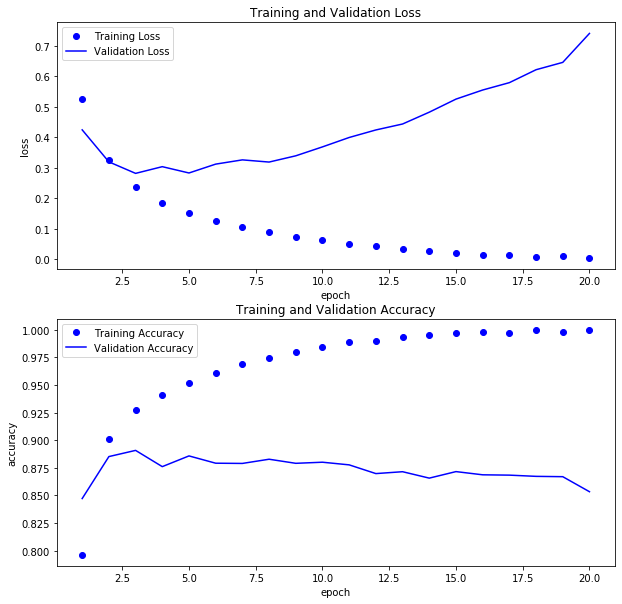

In [17]:
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(212)
plt.plot(epochs, acc, "bo", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Hyperfit

Try:
- one or three hidden layers
- more or less hidden units
- `mse` instead of `binary_crossentropy`
- `tanh` instead of `relu`

histogram output preds

In [0]:

def model_file_names(model_id):
  return (
      "model_{:03d}.json".format(model_id),
      "model_{:03d}.h5".format(model_id)
  )

def save_model_results(model_dict):
  json_fn, h5_fn = model_file_names(model_dict["model_id"])

  model = model_dict.pop("model")
  
  # save results JSON
  write_json(model_dict, json_fn)

  # save the model
  model.save(h5_fn)

def save_training_outputs(func):
  def wrapper(*args, **kwargs):
    model_dict = func(*args, **kwargs)
    save_model_results(model_dict)
    return model_dict
  return wrapper

def skip_already_trained(func):
  def wrapper(*args, **kwargs):
    model_id = kwargs["model_id"]
    json_fn, h5_fn = model_file_names(model_id)
    if os.path.exists(json_fn):
      print("Skipping model {}. Already completed.".format(model_id))
      return None
    return func(*args, **kwargs)
  return wrapper

@skip_already_trained
@save_training_outputs
def create_and_train_model(model_id, num_layers, num_hidden_units, loss_type,
                           activation, batch_size):
  model = models.Sequential()
  model.add(layers.Dense(num_hidden_units, activation=activation,
                         input_shape=(10000,)))
  for _ in range(1, num_layers):
    model.add(layers.Dense(num_hidden_units, activation=activation))
  model.add(layers.Dense(1, activation="sigmoid"))

  model.compile(
      optimizer="rmsprop",
      loss=loss_type,
      metrics=["accuracy"]
  )

  print("Training model {}".format(model_id))
  history = model.fit(
      partial_x_train,
      partial_y_train,
      epochs=10,
      batch_size=batch_size,
      validation_data=(x_val, y_val),
      verbose=0
  )
  history_dict = history.history
  accuracy = history_dict["accuracy"]
  val_accuracy = history_dict["val_accuracy"][-1]
  print("Validation accuracy: {}".format(val_accuracy))

  return {
      "model": model,
      "val_accuracy": val_accuracy,
      "model_id": model_id,
      "num_layers": num_layers,
      "num_hidden_units": num_hidden_units,
      "loss_type": loss_type,
      "activation": activation,
      "batch_size": batch_size
  }

In [20]:
model_kwargs_list = []

cur_model_id = 0
for num_layers in [3, 2, 1]:
  for num_hidden_units in [16, 32, 64]:
    for loss_type in ["binary_crossentropy", "mse"]:
      for activation in ["relu", "tanh"]:
        for batch_size in [32, 512, 1024]:          
          model_kwargs_list.append({
              "model_id": cur_model_id,
              "num_layers": num_layers,
              "num_hidden_units": num_hidden_units,
              "loss_type": loss_type,
              "activation": activation,
              "batch_size": batch_size
          })
          cur_model_id += 1

print("{} models to hyperfit over".format(len(model_kwargs_list)))

108 models to hyperfit over


In [21]:
for model_kwargs in model_kwargs_list:
  create_and_train_model(**model_kwargs)

Skipping model 0. Already completed.
Skipping model 1. Already completed.
Skipping model 2. Already completed.
Skipping model 3. Already completed.
Skipping model 4. Already completed.
Skipping model 5. Already completed.
Skipping model 6. Already completed.
Skipping model 7. Already completed.
Skipping model 8. Already completed.
Skipping model 9. Already completed.
Skipping model 10. Already completed.
Skipping model 11. Already completed.
Skipping model 12. Already completed.
Skipping model 13. Already completed.
Skipping model 14. Already completed.
Skipping model 15. Already completed.
Skipping model 16. Already completed.
Skipping model 17. Already completed.
Skipping model 18. Already completed.
Skipping model 19. Already completed.
Skipping model 20. Already completed.
Skipping model 21. Already completed.
Skipping model 22. Already completed.
Skipping model 23. Already completed.
Skipping model 24. Already completed.
Skipping model 25. Already completed.
Skipping model 26. Alr

In [0]:
model_dicts = {}
for model_id in range(108):
  json_fn, h5_fn = model_file_names(model_id)
  model_dict = read_json(json_fn)
  model_dict["val_accuracy"] = float(model_dict["val_accuracy"])
  model_dicts[model_id] = model_dict
  # model = models.load_model(h5_fn)
  # model.summary()

In [33]:
non_hyperparams = ["model_id", "val_accuracy"]
hyperparameters = list(model_dicts[0].keys())
hyperparameters = [x for x in hyperparameters if x not in non_hyperparams]
hyperparameters

['num_layers', 'num_hidden_units', 'loss_type', 'activation', 'batch_size']

In [87]:
num_layers_range = [3, 2, 1]
num_hidden_units_range = [16, 32, 64]
loss_type_range = ["binary_crossentropy", "mse"]
activation_range = ["relu", "tanh"]
batch_size_range = [32, 512, 1024]

for hyperparam_name, hyperparam_range in [
  ("num_layers", num_layers_range),
  ("num_hidden_units", num_hidden_units_range),
  ("loss_type", loss_type_range),
  ("activation", activation_range),
  ("batch_size", batch_size_range),
]:
  for hyperparam_val in hyperparam_range:
    dicts = {
        k: v for k, v in model_dicts.items()
        if v["activation"] == "relu"
    }
    cur_val_accs = [
      d["val_accuracy"] for d in dicts.values()
      if d[hyperparam_name] == hyperparam_val
    ]
    print("{} = {}".format(hyperparam_name, hyperparam_val))
    print("mean:   {:.3f}".format(np.mean(cur_val_accs)))
    print("stddev: {:.3f}".format(np.std(cur_val_accs)))
  print()

num_layers = 3
mean:   0.876
stddev: 0.005
num_layers = 2
mean:   0.874
stddev: 0.007
num_layers = 1
mean:   0.877
stddev: 0.007

num_hidden_units = 16
mean:   0.877
stddev: 0.008
num_hidden_units = 32
mean:   0.876
stddev: 0.006
num_hidden_units = 64
mean:   0.873
stddev: 0.005

loss_type = binary_crossentropy
mean:   0.876
stddev: 0.006
loss_type = mse
mean:   0.875
stddev: 0.007

activation = relu
mean:   0.875
stddev: 0.007
activation = tanh
mean:   nan
stddev: nan

batch_size = 32
mean:   0.869
stddev: 0.002
batch_size = 512
mean:   0.876
stddev: 0.005
batch_size = 1024
mean:   0.881
stddev: 0.007



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No handles with labels found to put in legend.


Activation relu: blue
Activation tanh: red
LossType binary_crossentropy: o
LossType mse: x


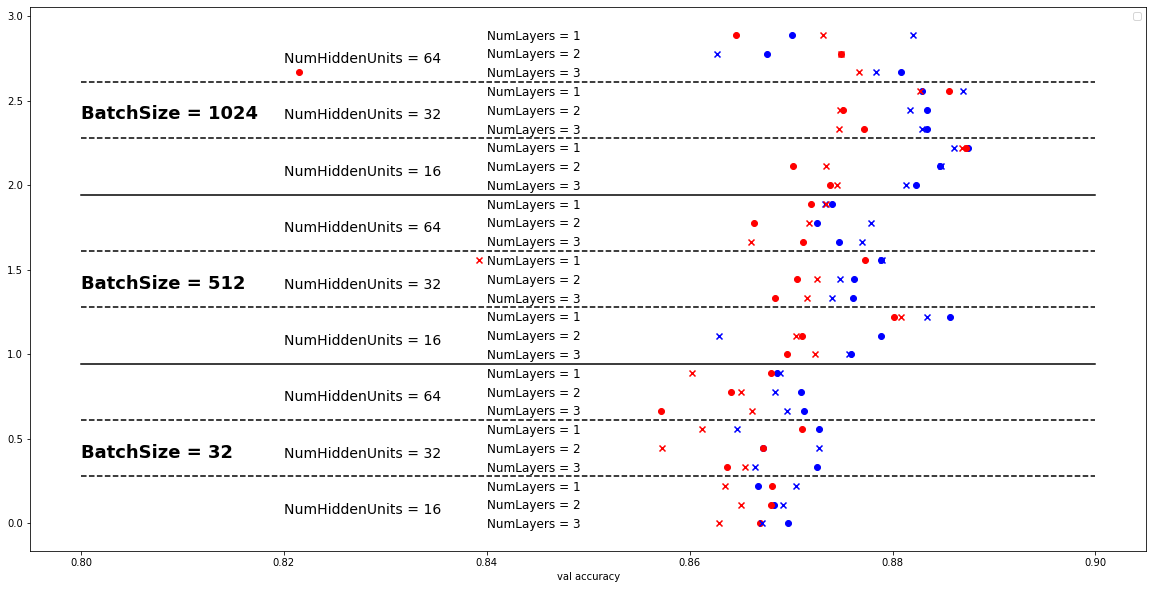

In [88]:
plt.figure(figsize=(20, 10))

x = np.linspace(0.8, 0.9, 10)
y = (1 - 1/18) * np.ones(x.shape)
plt.plot(x, y, "k")
y = (2 - 1/18) * np.ones(x.shape)
plt.plot(x, y, "k")

colors = ["blue", "red"]
markers = ["o", "x"]

for i in range(3):
  y = (i + 1/3 - 1/18) * np.ones(x.shape)
  plt.plot(x, y, "k--")
  y = (i + 2/3 - 1/18) * np.ones(x.shape)
  plt.plot(x, y, "k--")

for model_dict in model_dicts.values():
  model_id = model_dict["model_id"]
  val_accuracy = model_dict["val_accuracy"]

  num_layers = model_dict["num_layers"]
  num_hidden_units = model_dict["num_hidden_units"]
  loss_type = model_dict["loss_type"]
  activation = model_dict["activation"]
  batch_size = model_dict["batch_size"]

  # if activation == "tanh":
  #   continue

  plt.scatter(
      val_accuracy,
      (batch_size_range.index(batch_size)
       + num_hidden_units_range.index(num_hidden_units) * 1/3
       + num_layers_range.index(num_layers) * 1/9
      ),
      c=colors[activation_range.index(activation)],
      marker=markers[loss_type_range.index(loss_type)]
  )

for i in range(3):
  plt.text(
      0.8, i + 1/3 + 1/18,
      "BatchSize = {}".format(batch_size_range[i]),
      fontsize=18, weight="bold"
  )
  for j in range(3):
    plt.text(
        0.82, i + j/3 + 1/18,
        "NumHiddenUnits = {}".format(num_hidden_units_range[j]),
        fontsize=14
    )
    for k in range(3):
      plt.text(
          0.84, i + j/3 + k/9 - 1/36,
          "NumLayers = {}".format(num_layers_range[k]),
          fontsize=12
      )


plt.xlabel("val accuracy")
plt.legend();

for i in range(2):
  print("Activation {}: {}".format(activation_range[i], colors[i]))
for i in range(2):
  print("LossType {}: {}".format(loss_type_range[i], markers[i]))

In [99]:
model_id_score_pairs = [
  (d["model_id"], d["val_accuracy"])
  for d in model_dicts.values()
]
model_id_score_pairs.sort(key=lambda x: x[1], reverse=True)
model_id, val_acc = model_id_score_pairs[0]
print("Best Model: {}, {}".format(model_id, val_acc))

json_fn, h5_fn = model_file_names(model_id)
model = models.load_model(h5_fn)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

Best Model: 74, 0.8874
25000/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Observations:
*Nothing* effects more than ~5% accuracy

`batch_size` was the biggest factor, with larger better

`relu` `activation` is significantly better than `tanh`

`loss_type` was a tossup between `binary_crossentropy` and `mse`

the best networks were actually the smallest
- `num_layers` = 1
- `num_hidden_units` = 16

Test results for original model:
```
Test Loss: 0.8265587511157989
Test Accuracy: 0.8358399868011475
```

Test results for best hyperfit model:
```
Test Loss: 0.30350587461471557
Test Accuracy: 0.8765199780464172
```
Hyperfitting achieved a 4% improvement over the original model.